In [1]:
import sys
import yfinance as yf
import requests
from bs4 import BeautifulSoup
from prophet import Prophet
from pandas.plotting import autocorrelation_plot
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ta
import pandas_datareader as pdr
import pytictoc as tt
import plotly
from tickerTA import Ticker
from tickerTA import TechnicalAnalysis
from tradingStrategy1 import TradingStrategy1
from positions import Position
from positions import Positions

# This is to avoid the SettingWithCopyWarning in pandas
pd.options.mode.copy_on_write = True 

c:\Users\chris\Documents\Unreal Projects\AlgorithmicTrading\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_tickers500():
    url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    table = soup.find('table', {'id': 'constituents'})
    tickers500 = []
    for row in table.find_all('tr')[1:]:
        ticker = row.find('td').text.strip()
        tickers500.append(ticker)
    return tickers500

def add_z_score(data: pd.DataFrame, frame: str = 'Adj Close', window1 = 20) -> pd.DataFrame:
    data['Z Score ' + frame] = (data[frame] - data[frame].rolling(window= window1).mean()) / data[frame].rolling(window= window1).std()
    data.dropna(inplace=True)
    return data

def get_z_score(data: pd.DataFrame, frame: str = 'Adj Close', window1 = 20) -> pd.DataFrame:
    data['Z Score ' + frame] = (data[frame] - data[frame].rolling(window= window1).mean()) / data[frame].rolling(window= window1).std()
    data.dropna(inplace=True)
    return data['Z Score ' + frame]

def plot_total_cum_profit(self, start='2022-01-31', end='2024-01-31'):
    self['Total Cum Profit %'] = self['Profit %'].cumsum()
    self.reset_index(inplace=True)
    self.index = pd.to_datetime(self['Buy Date'])
    plt.figure(figsize=(20, 10))
    plt.plot(self['Buy Date'], self['Total Cum Profit %'], drawstyle="steps-post", label='Total Cumulative Profit', alpha=1)

    spy_df = yf.download('SPY', start, end, progress=False)
    spy_df['Control'] = spy_df['Close'] - spy_df['Open']
    spy_df['Control %'] = (spy_df['Control'] / spy_df['Open']) * 100
    spy_df['Control Cumulative %'] = spy_df['Control %'].cumsum()
    plt.plot(spy_df['Control Cumulative %'], drawstyle="steps-post", label='SPY', alpha=0.8)

    plt.title('Total Cumulative Profit % vs SPY')
    plt.legend(loc='upper left')
    plt.savefig('tradingStrategy1/total_cum_profit.png')
    # plt.show()

    plt.close()

In [3]:

if __name__ == '__main__':
    tickers500 = get_tickers500()
    # stock_df = pd.DataFrame()
    tradingstrategy1_df = pd.DataFrame()
    all_signals_df = pd.DataFrame()
    positions = Positions(100000)


    for ticker in tickers500:
        stock = Ticker(ticker, start='2022-01-31', end='2024-01-31')
        # stock_df = stock_df._append(stock.df)
        techA = TechnicalAnalysis(stock)
        tradingS = TradingStrategy1(techA)
        all_signals_df = all_signals_df._append(tradingS.all_signals_df)
        tradingstrategy1_df = tradingstrategy1_df._append(tradingS.trades_df)

    plot_total_cum_profit(tradingstrategy1_df)
    # print(tradingstrategy1_df['Total Cum Profit %'])

c:\Users\chris\Documents\Unreal Projects\AlgorithmicTrading\tradingStrategy1.py:51: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.all_signals_df = self.all_signals_df._append({'Ticker': self.symbol, 'Buy/Sell': 'Buy', 'Date': index, 'Price': row['Open']}, ignore_index=True)
c:\Users\chris\Documents\Unreal Projects\AlgorithmicTrading\tradingStrategy1.py:51: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.all_signals_df = self.all_signals_df._append({'Ticker': self.symbol, 'Buy/Sell': 'Buy

In [20]:
all_signals_df = all_signals_df.sort_values(by='Date')
all_signals_df

,Ticker,Buy/Sell,Date,Price
0,LOW,Buy,2022-03-28,211.38
0,BBY,Buy,2022-04-01,92.32
0,NVR,Buy,2022-04-01,4519.58
0,C,Buy,2022-04-01,53.47
0,HCA,Buy,2022-04-01,251.00
...,...,...,...,...
11,COF,Sell,2024-01-29,139.64
9,PSX,Sell,2024-01-29,139.66
13,DLR,Sell,2024-01-29,142.83
14,INTC,Buy,2024-01-29,43.71


In [166]:
positions = Positions(100000)
posn_size = 10000

for _, row in all_signals_df.iterrows():
    if row['Buy/Sell'] == 'Buy':
        shares = posn_size / row['Price']
        shares = shares.__round__(0)
        if shares > 0:
            positions.buy(row['Ticker'], row['Date'], row['Price'], shares)
        else:
            print(f'Not enough money to buy {row["Ticker"]} on {row["Date"]}')
    else:
        positions.sell(row['Ticker'], row['Date'], row['Price'])


Not enough capital to buy 225.0 shares of WBA
Not enough capital to buy 235.0 shares of PHM
Not enough capital to buy 57.0 shares of WHR
Not enough capital to buy 155.0 shares of AOS
Not enough capital to buy 182.0 shares of TFC
Not enough capital to buy 463.0 shares of KEY
Not enough capital to buy 55.0 shares of JBHT
Not enough capital to buy 228.0 shares of CFG
Not enough capital to buy 61.0 shares of MTB
Not enough capital to buy 36.0 shares of ODFL
Not enough capital to buy 133.0 shares of BAX
Not enough capital to buy 72.0 shares of UHS
Not enough capital to buy 51.0 shares of UPS
Not enough capital to buy 244.0 shares of FITB
Not enough capital to buy 637.0 shares of HPE
Not enough capital to buy 86.0 shares of QRVO
Not enough capital to buy 182.0 shares of PCAR
Not enough capital to buy 23.0 shares of FICO
Not enough capital to buy 33.0 shares of MKTX
Not enough capital to buy 284.0 shares of GLW
Not enough capital to buy 94.0 shares of ALLE
Not enough capital to buy 72.0 share

In [167]:
print(positions.get_open_positions())

[{'symbol': 'HUM', 'buy_date': Timestamp('2023-11-03 00:00:00'), 'buy_price': 478.46, 'shares': 21.0}, {'symbol': 'EQT', 'buy_date': Timestamp('2023-11-09 00:00:00'), 'buy_price': 40.09, 'shares': 249.0}, {'symbol': 'SBUX', 'buy_date': Timestamp('2023-12-05 00:00:00'), 'buy_price': 97.38, 'shares': 103.0}, {'symbol': 'FANG', 'buy_date': Timestamp('2023-12-06 00:00:00'), 'buy_price': 148.74, 'shares': 67.0}, {'symbol': 'CAH', 'buy_date': Timestamp('2023-12-15 00:00:00'), 'buy_price': 102.05, 'shares': 98.0}, {'symbol': 'CPRT', 'buy_date': Timestamp('2024-01-04 00:00:00'), 'buy_price': 46.72, 'shares': 214.0}, {'symbol': 'GRMN', 'buy_date': Timestamp('2024-01-10 00:00:00'), 'buy_price': 122.67, 'shares': 82.0}, {'symbol': 'WFC', 'buy_date': Timestamp('2024-01-16 00:00:00'), 'buy_price': 46.77, 'shares': 214.0}, {'symbol': 'IEX', 'buy_date': Timestamp('2024-01-16 00:00:00'), 'buy_price': 205.55, 'shares': 49.0}, {'symbol': 'MTB', 'buy_date': Timestamp('2024-01-17 00:00:00'), 'buy_price': 

In [168]:
positions.capital

3180.650000000025

In [169]:

positions.cancel_open_positions()
print(positions.get_open_positions())



[]


In [170]:
positions.capital

103269.98000000003

In [171]:

positions.trade_history_df.to_csv('CSV/TradingStrategy1/Positions/tradingstrategy1trades.csv')
positions.trade_history_df

,symbol,buy_date,buy_price,sell_date,sell_price,shares,profit,profit_percent
0,HAS,2022-04-01,82.34,2022-04-21,89.27,121.0,838.53,8.416323
1,HCA,2022-04-01,251.00,2022-04-21,273.98,40.0,919.20,9.155378
2,NVR,2022-04-01,4519.58,2022-05-05,4595.68,2.0,152.20,1.683785
3,LHX,2022-04-22,246.78,2022-06-08,245.46,41.0,-54.12,-0.534889
4,C,2022-04-01,53.47,2022-07-18,50.66,187.0,-525.47,-5.255283
...,...,...,...,...,...,...,...,...
76,LVS,2023-11-30,45.50,2024-01-03,50.69,220.0,1141.80,11.406593
77,J,2023-11-22,123.58,2024-01-10,130.90,81.0,592.92,5.923289
78,MMC,2023-12-15,188.59,2024-01-16,195.92,53.0,388.49,3.886738
79,CBOE,2023-12-15,172.06,2024-01-16,181.06,58.0,522.00,5.230733


<Axes: >

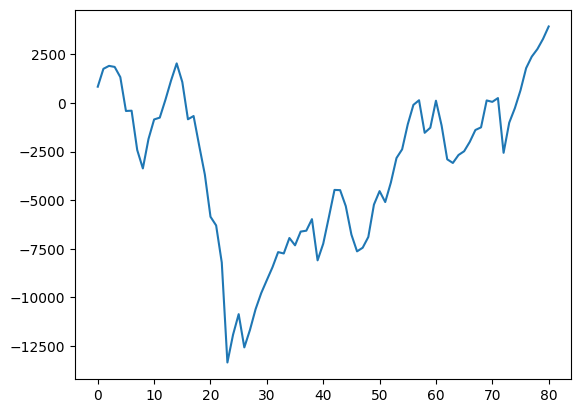

In [172]:
positions.trade_history_df['profit'].cumsum().plot()

<Axes: >

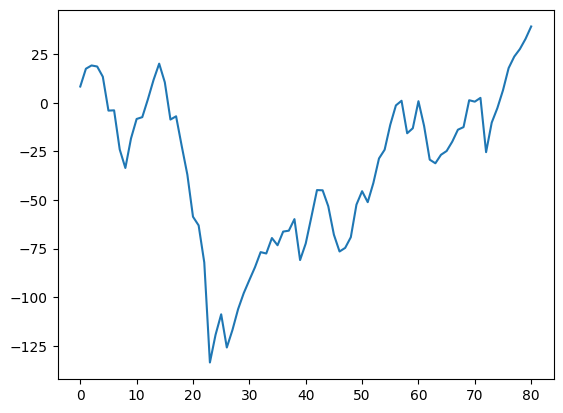

In [173]:
positions.trade_history_df['profit_percent'].cumsum().plot()

In [174]:
print('Total Profit: $', positions.total_profit.__round__(2))

Total Profit: $ 3936.1


In [175]:
print('Capital: $', positions.capital.__round__(2))

Capital: $ 103269.98


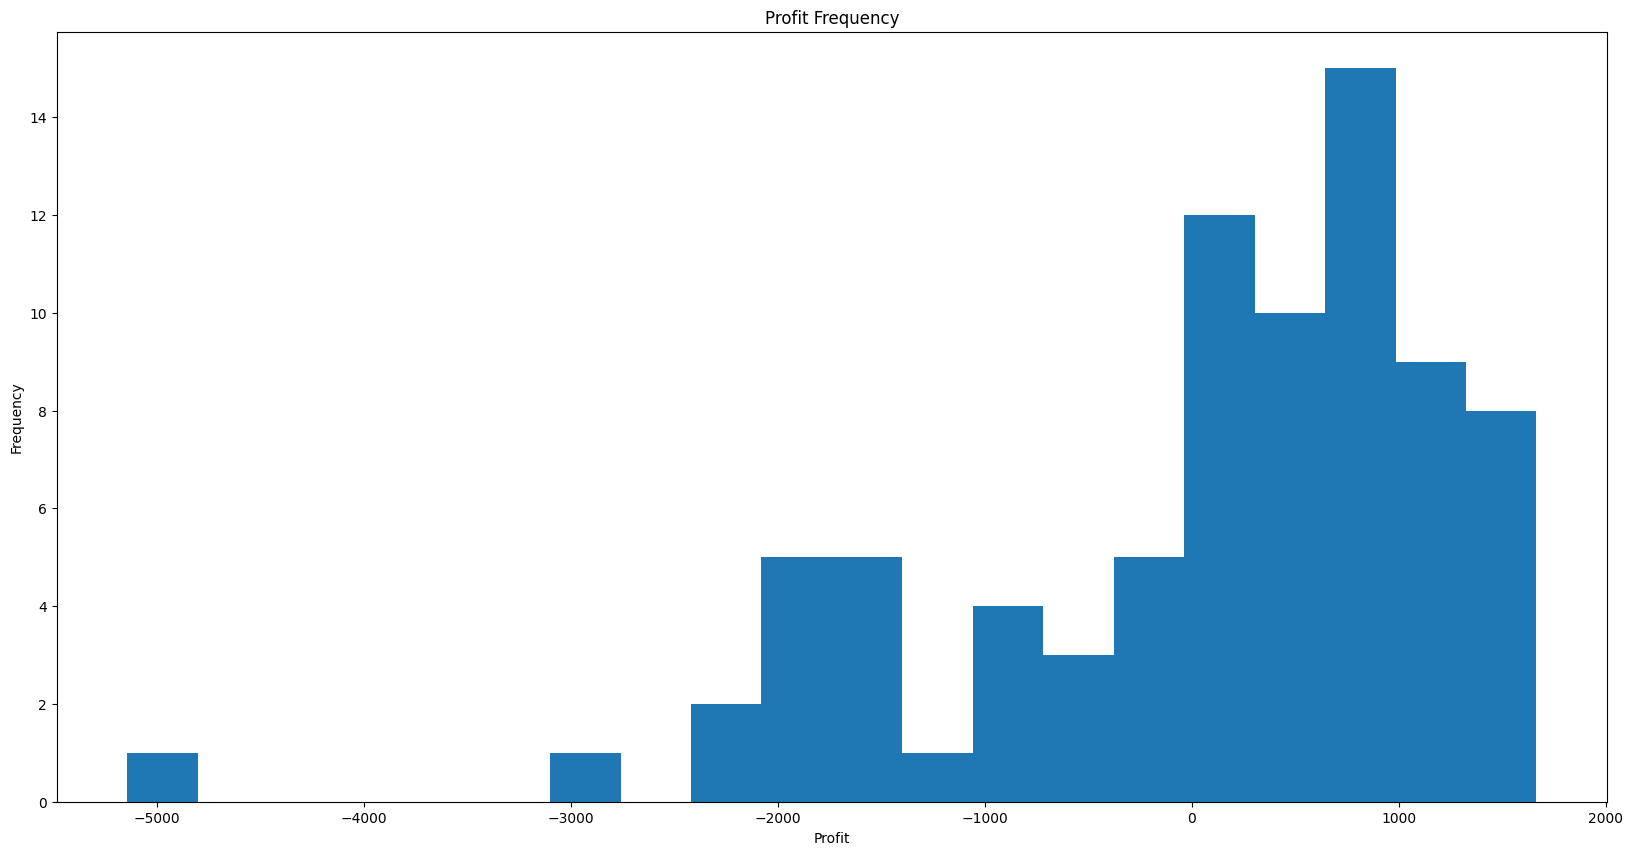

In [176]:
positions.plot_profit_frequency()

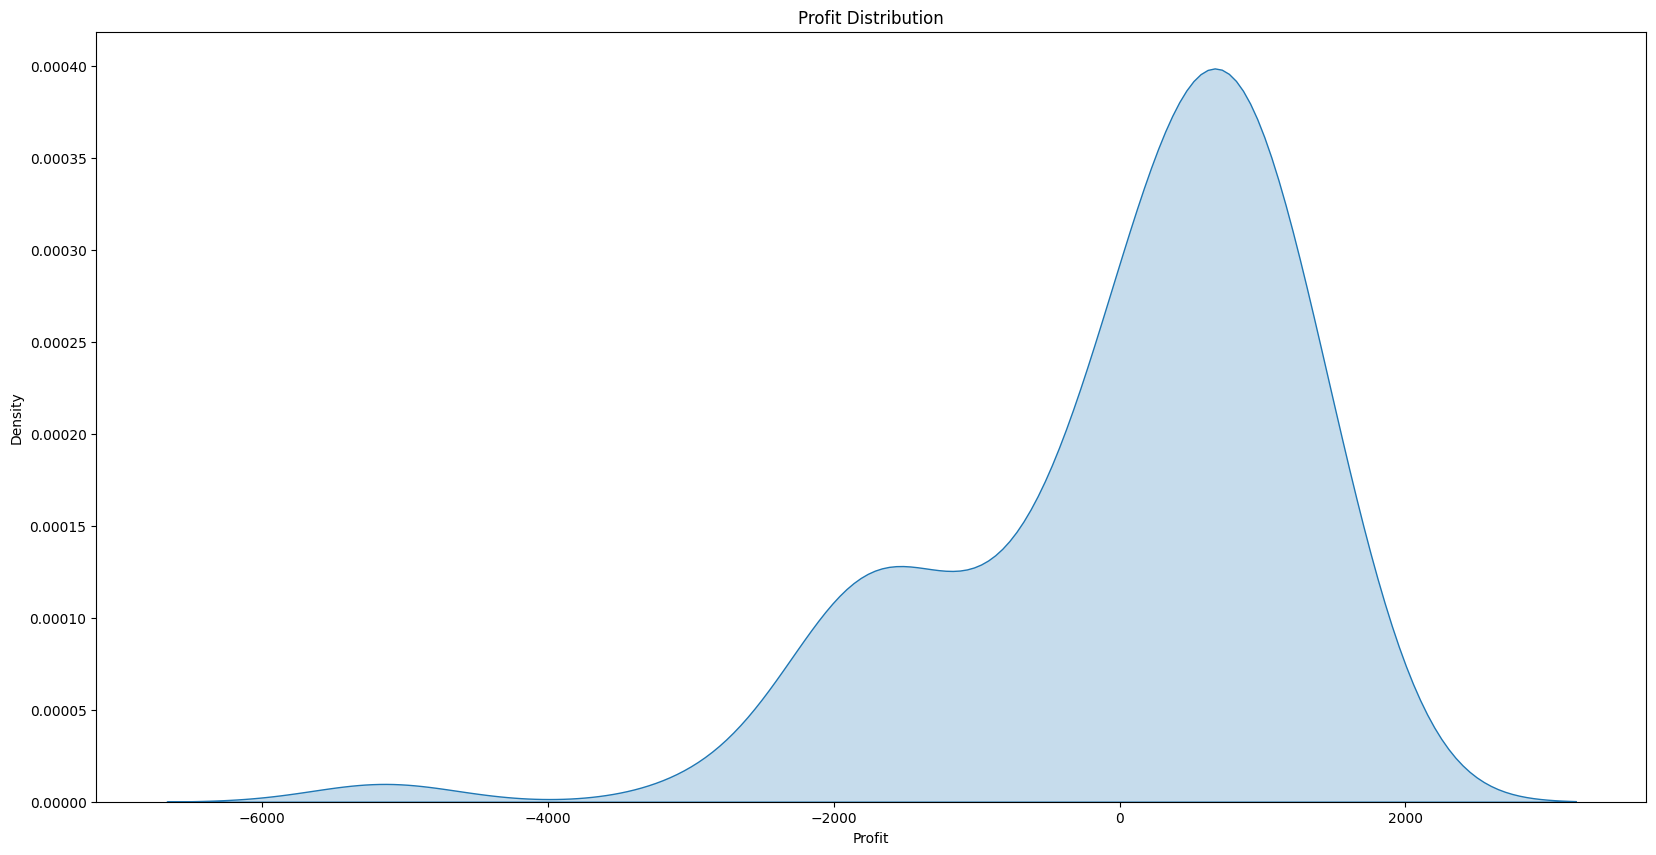

In [177]:
positions.plot_profit_distribution()

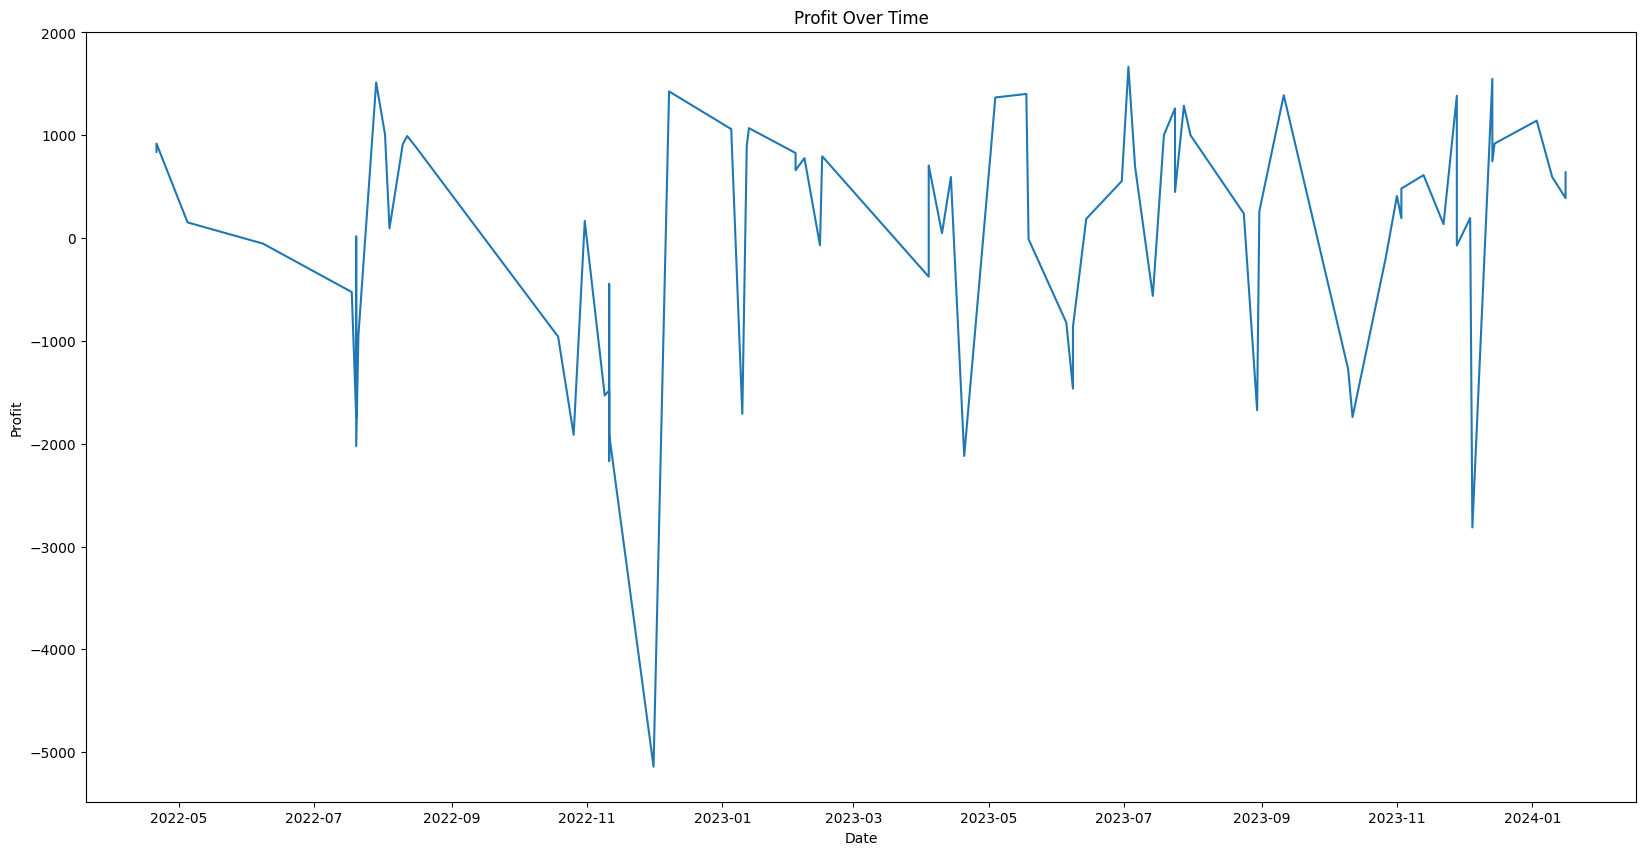

In [178]:
positions.plot_profit_time()

In [179]:
print('Total Profit : ', ((positions.capital - positions.starting_capital) / positions.starting_capital * 100).__round__(2), '%')

Total Profit :  3.27 %


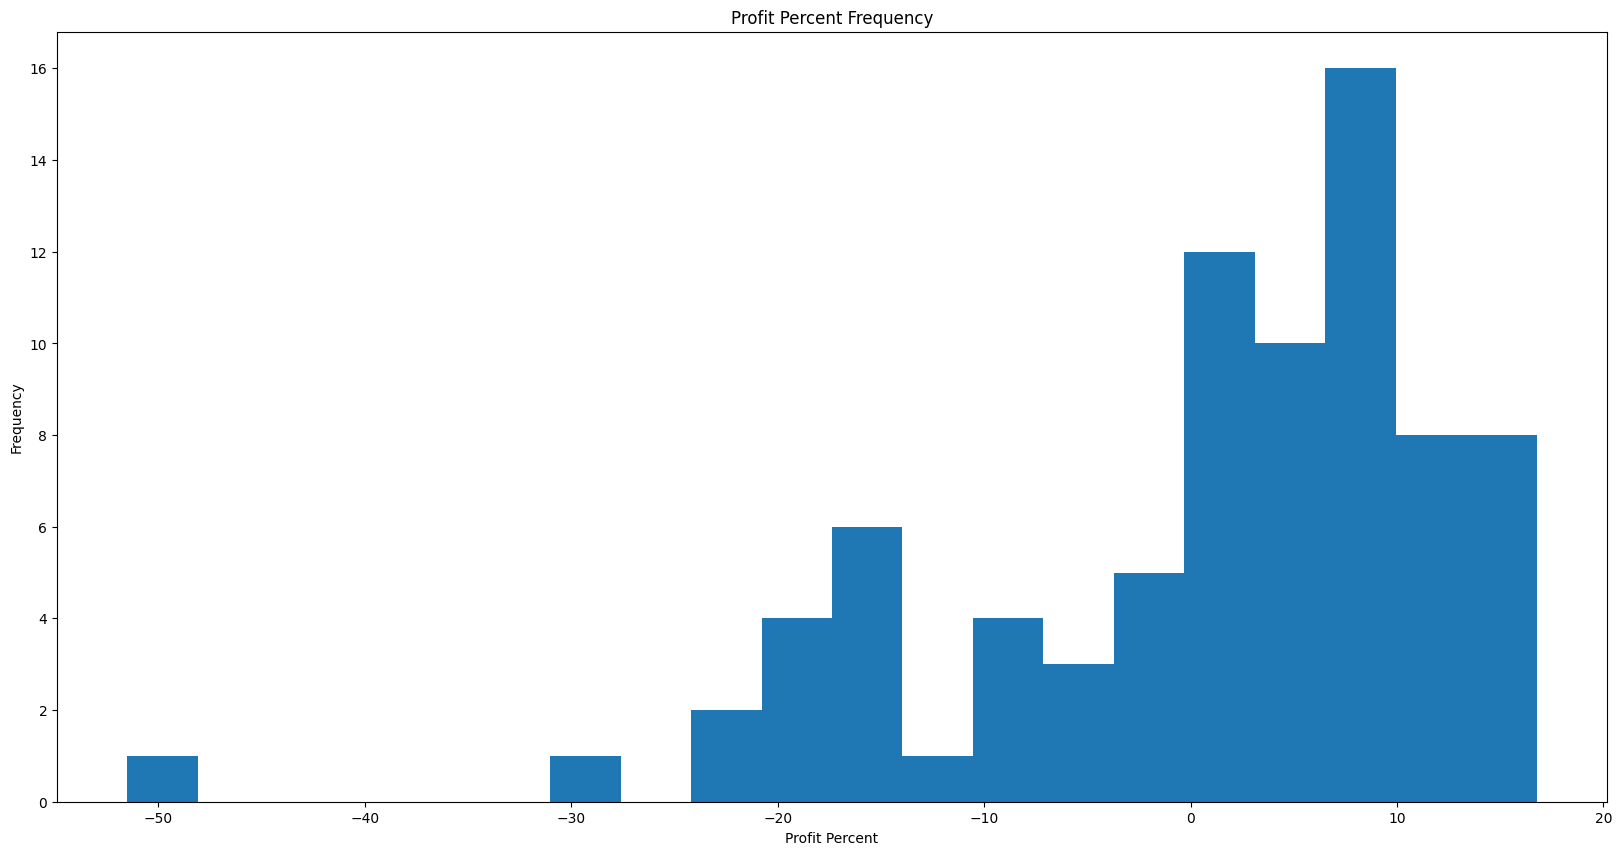

In [180]:
positions.plot_profit_percent_frequency()

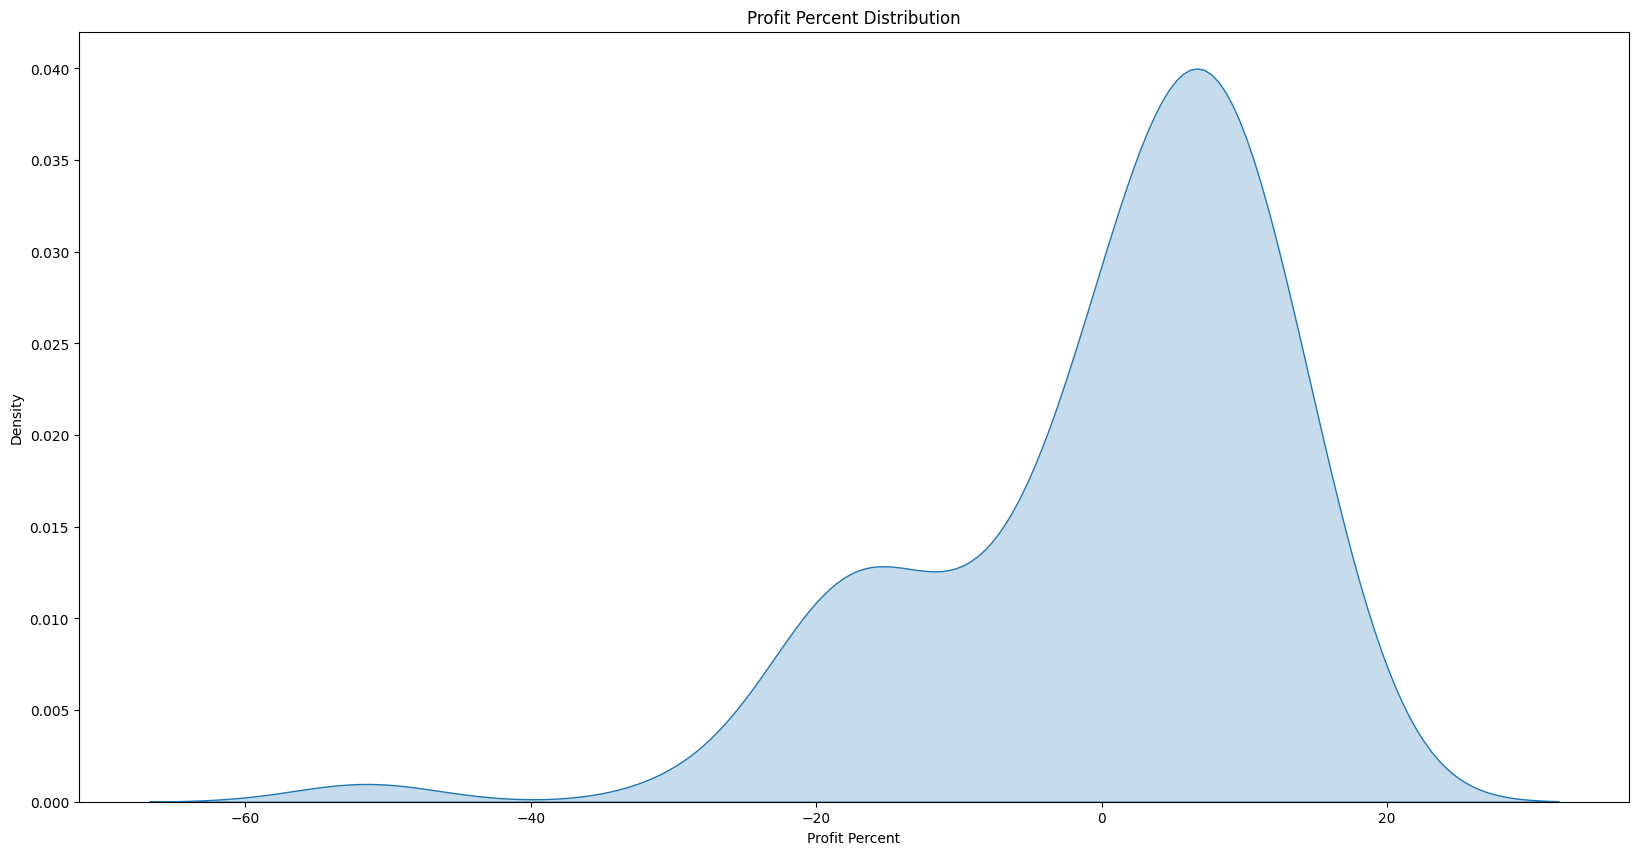

In [181]:
positions.plot_profit_percent_distribution()

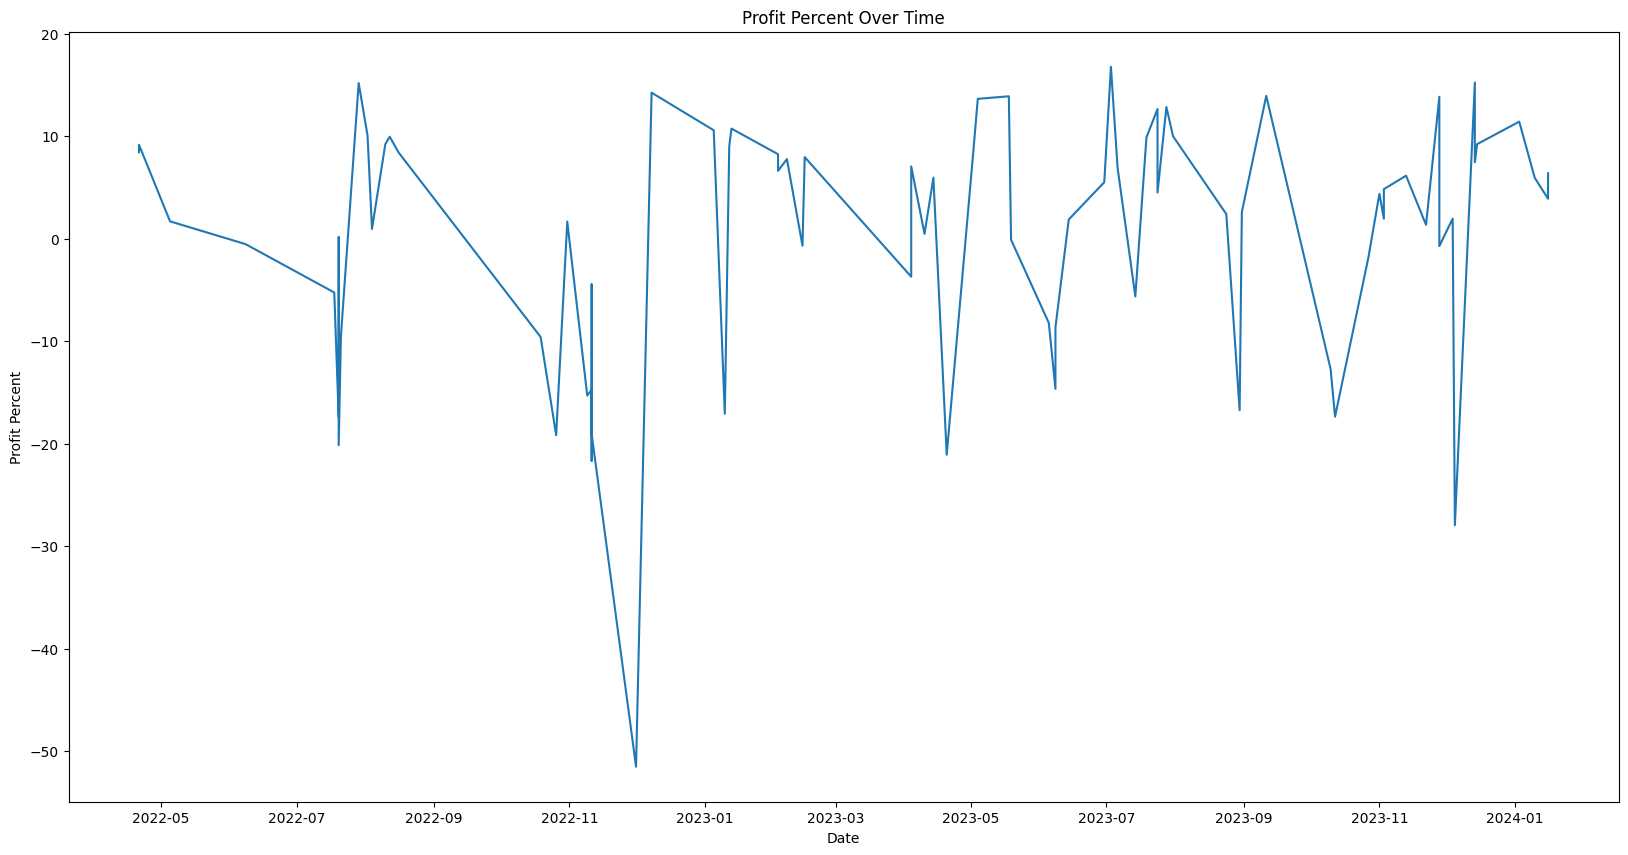

In [182]:
positions.plot_profit_percent_time()

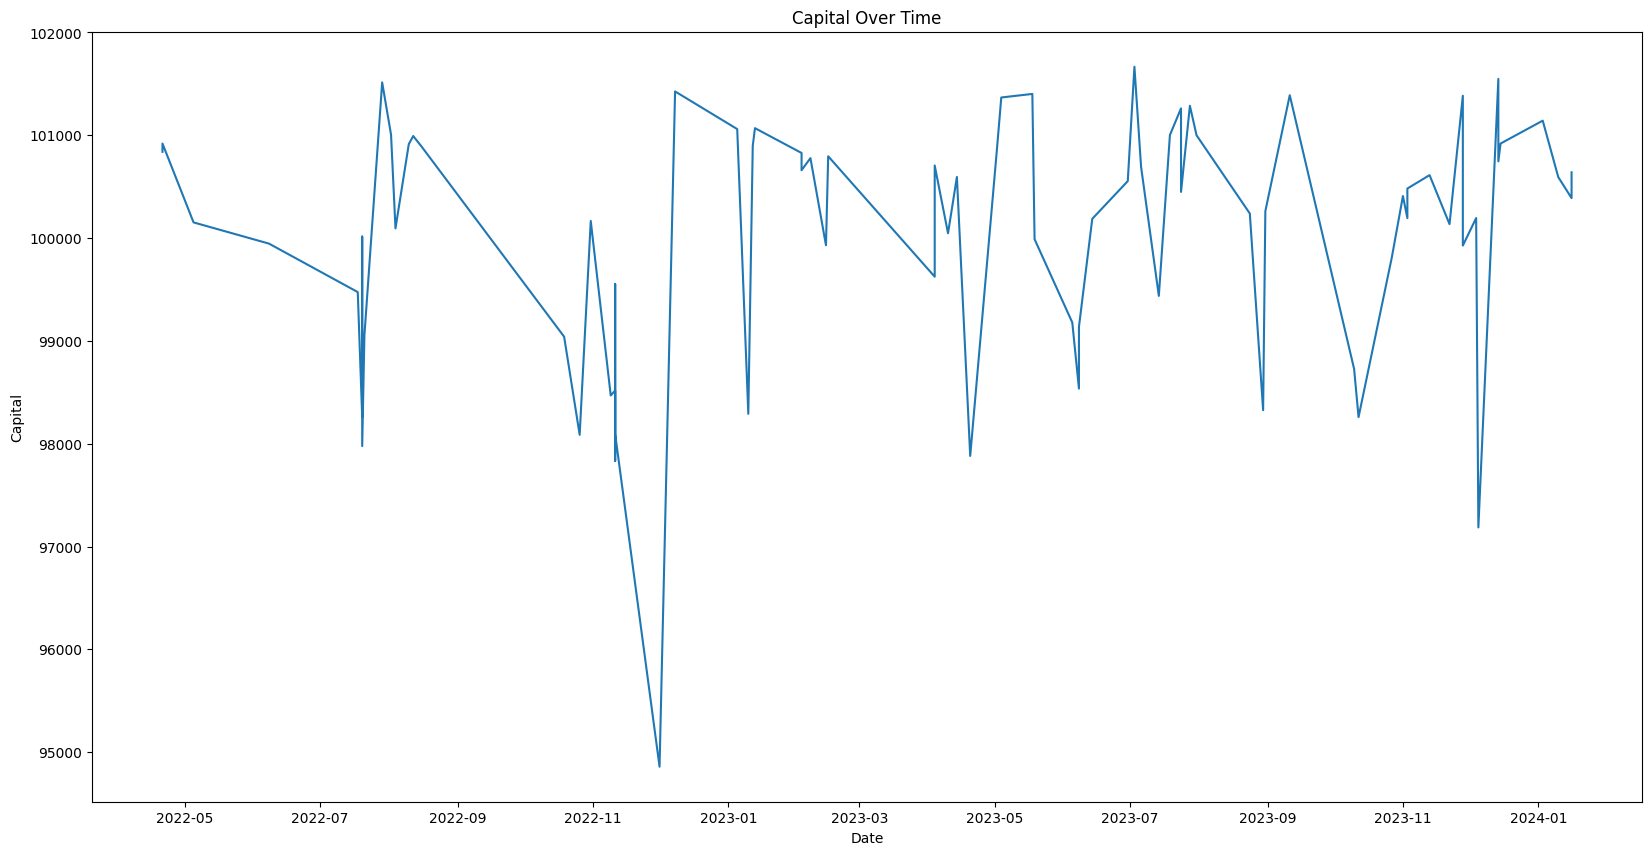

In [183]:
positions.plot_capital_time()

In [184]:
positions.calculate_metrics()
positions.get_metrics()

{'Sharpe Ratio': 0.039897650909130875,
 'Profit Percent': 3.27,
 'Win Rate': 65.4320987654321,
 'Max Drawdown': -4.396591359492667,
 'Sortino Ratio': 0.045864485278972654,
 'Profit Factor': 1.107543069413244,
 'Expectancy': -542.3144878706199,
 'R Squared': 0.20471082030350413}